### Comparing Aggregate Models for Regression

This try-it focuses on utilizing ensemble models in a regression setting.  Much like you have used individual classification estimators to form an ensemble of estimators -- here your goal is to explore ensembles for regression models.  As with your earlier assignment, you will use scikitlearn to carry out the ensembles using the `VotingRegressor`.   


#### Dataset and Task

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  Your task is to use ensemble methods to explore predicting the `wage` column of the data.  Your ensemble should at the very least consider the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

Tune the `VotingRegressor` to try to optimize the prediction performance and determine if the wisdom of the crowd performed better in this setting than any of the individual models themselves.  Report back on your findings and discuss the interpretability of your findings.  Is there a way to determine what features mattered in predicting wages?

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [30]:
survey = fetch_openml(data_id=534, as_frame=True).frame

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [32]:
survey.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


#### Encode Columns

In [35]:
# Selecting non-numerical columns
non_numerical_cols = ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']

# Displaying unique values for each non-numerical column
for col in non_numerical_cols:
    print(f"Unique values in column '{col}':")
    print(survey[col].unique())
    print("\n")

Unique values in column 'SOUTH':
['no', 'yes']
Categories (2, object): ['no', 'yes']


Unique values in column 'SEX':
['female', 'male']
Categories (2, object): ['female', 'male']


Unique values in column 'UNION':
['not_member', 'member']
Categories (2, object): ['member', 'not_member']


Unique values in column 'RACE':
['Hispanic', 'White', 'Other']
Categories (3, object): ['Hispanic', 'Other', 'White']


Unique values in column 'OCCUPATION':
['Other', 'Management', 'Sales', 'Clerical', 'Service', 'Professional']
Categories (6, object): ['Clerical', 'Management', 'Other', 'Professional', 'Sales', 'Service']


Unique values in column 'SECTOR':
['Manufacturing', 'Other', 'Construction']
Categories (3, object): ['Construction', 'Manufacturing', 'Other']


Unique values in column 'MARR':
['Married', 'Unmarried']
Categories (2, object): ['Married', 'Unmarried']




In [37]:
#Binary Encode appropriate columns
survey['SOUTH'] = survey['SOUTH'].map({'no': 0, 'yes': 1})
survey['SEX'] = survey['SEX'].map({'female': 0, 'male': 1})
survey['UNION'] = survey['UNION'].map({'not_member': 0, 'member': 1})
survey['MARR'] = survey['MARR'].map({'Unmarried': 0, 'Married': 1})

#One Hot Encode remaining columns
survey = pd.get_dummies(survey, columns=['RACE', 'OCCUPATION', 'SECTOR'], drop_first=True, dtype=int)

survey.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,MARR,RACE_Other,RACE_White,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Manufacturing,SECTOR_Other
0,8,0,0,21,0,5.10,35,1,0,0,0,1,0,0,0,1,0
1,9,0,0,42,0,4.95,57,1,0,1,0,1,0,0,0,1,0
2,12,0,1,1,0,6.67,19,0,0,1,0,1,0,0,0,1,0
3,12,0,1,4,0,4.00,22,0,0,1,0,1,0,0,0,0,1
4,12,0,1,17,0,7.50,35,1,0,1,0,1,0,0,0,0,1


#### Define and Train Each Model

In [43]:
# Define features (X) and target (y)
X = survey.drop(columns=['WAGE'])
y = survey['WAGE']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for certain models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
lr = TransformedTargetRegressor(regressor=LinearRegression(), transformer=StandardScaler())
ridge = Ridge()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=42)
svr = SVR()

# Fit individual models
lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)
dtr.fit(X_train, y_train)  # Decision tree does not need scaling
svr.fit(X_train_scaled, y_train)

SVR()

In [45]:
# Calculate predictions
results = {'Linear Regression': [],
          'Ridge': [],
          'KNN': [],
          'Desicion Tree': [],
          'SVR': []}

models = {'Linear Regression': lr, 'Ridge': ridge, 'KNN': knn, 'Decision Tree': dtr, 'SVR': svr}

i = 0
for name, model in models.items():
    y_pred = model.predict(X_test_scaled if name != 'Decision Tree' else X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[list(results.keys())[i]] = mse
    i += 1

results

{'Linear Regression': 19.502597324112383,
 'Ridge': 19.495888447445065,
 'KNN': 22.875903850467285,
 'Desicion Tree': 45.396833878504665,
 'SVR': 21.70955180758242}

In [55]:
# Define VotingRegressor
voting_reg = VotingRegressor(estimators=[
    ('lr', lr),
    ('ridge', ridge),
    ('knn', knn),
    ('dtr', dtr),
    ('svr', svr)
])

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'weights': [[1, 1, 0, 0, 0], [3, 3, 2, 1, 2], [2, 2, 1, 0, 1]]
}
grid_search = GridSearchCV(voting_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Evaluate the best VotingRegressor
best_voting_reg = grid_search.best_estimator_
y_pred_voting = best_voting_reg.predict(X_test_scaled)
mse_voting = mean_squared_error(y_test, y_pred_voting)
print(f'Voting Regressor MSE: {mse_voting:.4f}')
print(f'Best weights: {grid_search.best_params_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Voting Regressor MSE: 19.4992
Best weights: {'weights': [1, 1, 0, 0, 0]}


In [57]:
grid_search.cv_results_

{'mean_fit_time': array([0.01474814, 0.01404057, 0.01360521]),
 'std_fit_time': array([0.00026828, 0.00045424, 0.00028289]),
 'mean_score_time': array([0.00865912, 0.00798521, 0.00811062]),
 'std_score_time': array([0.00076747, 0.00044622, 0.00043113]),
 'param_weights': masked_array(data=[list([1, 1, 0, 0, 0]), list([3, 3, 2, 1, 2]),
                    list([2, 2, 1, 0, 1])],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'weights': [1, 1, 0, 0, 0]},
  {'weights': [3, 3, 2, 1, 2]},
  {'weights': [2, 2, 1, 0, 1]}],
 'split0_test_score': array([-15.72641067, -17.25138054, -15.99910838]),
 'split1_test_score': array([-13.76629892, -13.06249355, -13.34456831]),
 'split2_test_score': array([-27.10091621, -27.86277692, -27.50910779]),
 'split3_test_score': array([-20.95487832, -20.60858698, -20.91318347]),
 'split4_test_score': array([-16.77729127, -18.15991164, -17.33675668]),
 'mean_test_score': array([-18.86515908, -19.38902993

#### Feature Importance Analysis

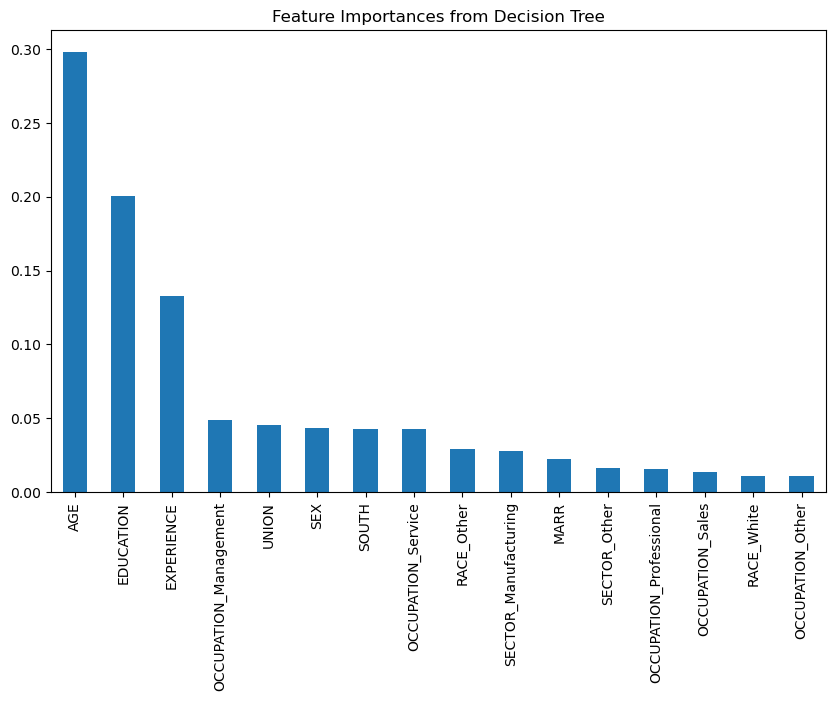

In [60]:
# Get feature importances
feature_importances = pd.Series(dtr.feature_importances_, index=X.columns)

# Plot feature importances
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Decision Tree')
plt.show()

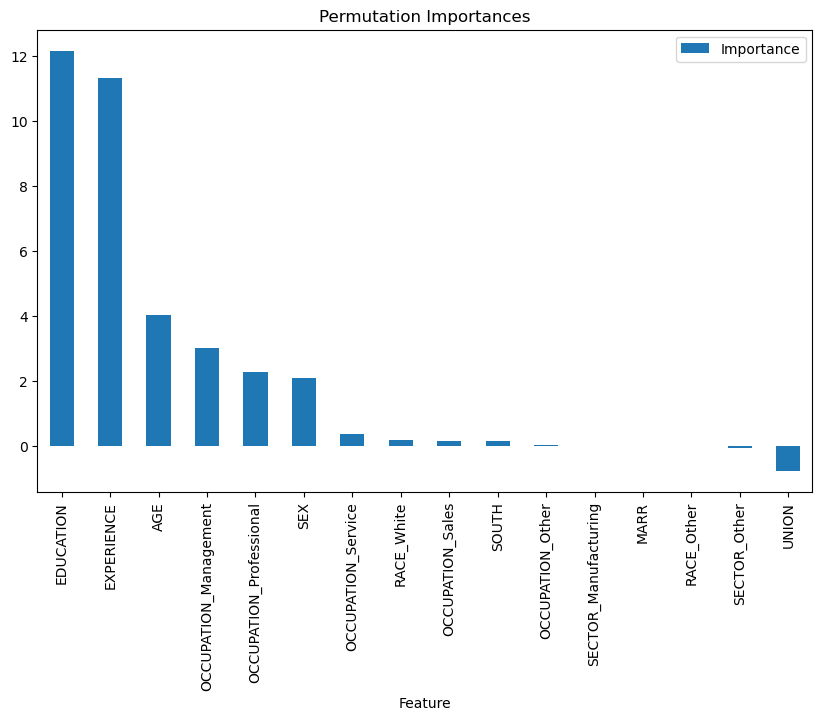

In [64]:
# Using the best Voting Regressor as an example
result = permutation_importance(best_voting_reg, X_test_scaled, y_test, scoring='neg_mean_squared_error', random_state=42)

# Convert to DataFrame for visualization
perm_importance = pd.DataFrame(
    {'Feature': X.columns, 'Importance': result.importances_mean}
).sort_values(by='Importance', ascending=False)

# Plot permutation importance
perm_importance.plot(x='Feature', y='Importance', kind='bar', figsize=(10, 6))
plt.title('Permutation Importances')
plt.show()

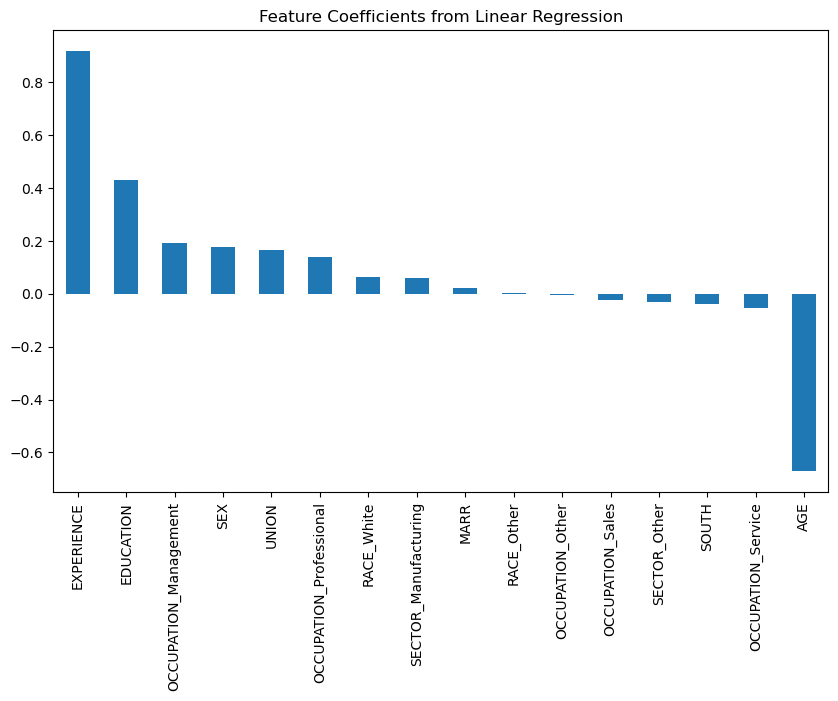

In [66]:
# Assuming you used Ridge or Linear Regression
coefficients = pd.Series(lr.regressor_.coef_, index=X.columns)

# Sort and plot
coefficients.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Coefficients from Linear Regression')
plt.show()